<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install nltk
!pip install nxviz

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx
import nxviz as nv
from nxviz import annotate
import seaborn as sns
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [53]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",n/a,n/a,n/a,Peter Anthony DeFazio\nDemocratic Party
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",n/a,n/a,n/a,Raymond Eugene “Gene” Green\n Democratic Party
1996-05-23,"When wages fall, buying power drops, and all t...",n/a,n/a,n/a,Ronald Paul Klink\nDemocratic Party
1999-10-13,These arguments are no truer today than they w...,n/a,n/a,n/a,Paul David Wellstone\nDemocratic Party
1999-10-27,Go right back to Alexander Hamilton in the ear...,n/a,n/a,n/a,Ernest Frederick “Fritz” Hollings\nDemocratic ...


In [54]:
def create_dates_list(df):
  return df.index
create_dates_list(df)

DatetimeIndex(['1995-05-23', '1996-05-23', '1996-05-23', '1999-10-13',
               '1999-10-27', '1999-10-28', '1999-11-01', '1999-11-02',
               '1999-11-09', '1999-11-09',
               ...
               '2019-03-07', '2019-12-10', '2020-10-01', '2020-12-21',
               '2021-03-19', '2021-10-06', '2021-10-07', '2022-07-19',
               '2022-07-26', '2023-03-09'],
              dtype='datetime64[ns]', name='Date', length=107, freq=None)

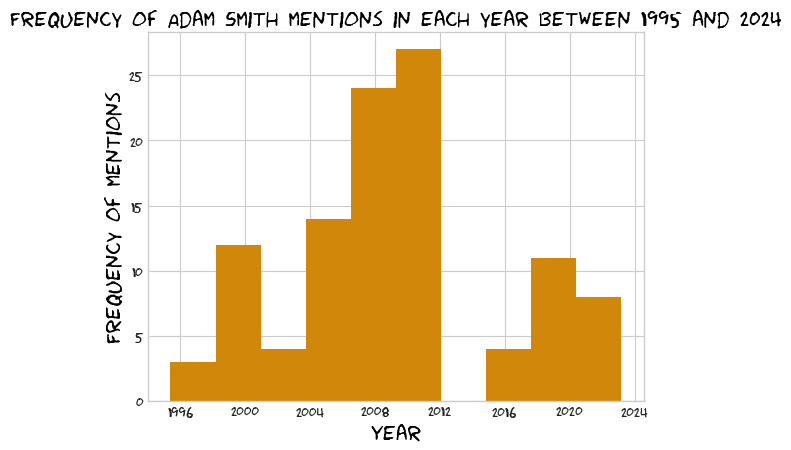

In [55]:
def create_histogram(df):
  #styles 'fast','fivethirtyeight'',',''seaborn-v0_8-whitegrid'
  fig, ax = plt.subplots()
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [56]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['As', 'everybody', 'knows', ',', 'a', 'little', 'earlier', 'this', 'year', ',']


In [57]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower()for t in nested_list] for nested_list in list_of_lists]
  alpha_num_only = [[t for t in token_list if t.isalnum()] for token_list in lower_tokens]
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.extend(['adam', 'smith', 'u'])
  no_stops = [[t for t in alpha_list if t not in stopwords] for alpha_list in alpha_num_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized
preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['everybody', 'know', 'little', 'earlier', 'year', 'part', 'record', 'trade', 'deficit', 'led']


In [58]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [59]:
def find_most_frequently_occuring_pairs(corpus):
  word_id_list_of_lists = [[i[0] for i in j] for j in corpus]
  pair_list_of_lists = [list(itertools.combinations(nested_list,2)) for nested_list in word_id_list_of_lists]
  catalogue_of_occurences = collections.defaultdict(int)
  for list_of_pairs in pair_list_of_lists:
    for pair in list_of_pairs:
      catalogue_of_occurences[pair]+=1
  most_frequently_occuring_pairs = sorted(list(catalogue_of_occurences.items()), key=lambda x: x[1], reverse=True)
  return most_frequently_occuring_pairs
most_frequently_occuring_pairs = find_most_frequently_occuring_pairs(corpus)
print(most_frequently_occuring_pairs[:10])

[((333, 338), 25), ((126, 137), 21), ((126, 333), 16), ((338, 398), 15), ((126, 338), 14), ((128, 133), 13), ((333, 398), 12), ((137, 338), 11), ((126, 177), 10), ((55, 126), 10)]


In [60]:
for nested_tuple in most_frequently_occuring_pairs[:10]:
  print(dictionary.get(nested_tuple[0][0]), dictionary.get(nested_tuple[0][1]))

nation wealth
free market
free nation
wealth 1776
free wealth
hand invisible
nation 1776
market wealth
free capitalism
trade free


In [61]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(137, 60), (126, 50), (333, 38), (338, 36), (96, 27), (108, 27), (55, 26), (320, 24), (10, 22), (62, 22)]


In [62]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

market 60
free 50
nation 38
wealth 36
government 27
would 27
trade 26
people 24
country 22
year 22
capitalism 22
hand 20
one 20
produce 19
world 18
u 18
invisible 18
going 18
1776 18
cost 18


In [63]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=0
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      all_tfidf_weights.append(tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[0][:20]:
  print(dictionary.get(term_id), weight)

1980 0.1209848088516904
200 0.10303844656945416
airplane 0.1209848088516904
america 0.11780119146600504
basket 0.1209848088516904
bit 0.10303844656945416
britain 0.09254049760998939
came 0.10303844656945416
case 0.1209848088516904
continue 0.0850920842872179
country 0.046149824086052164
dead 0.1209848088516904
deficit 0.1209848088516904
dictate 0.2419696177033808
dollar 0.2060768931389083
doorstep 0.1209848088516904
earlier 0.1209848088516904
early 0.07931464606753919
economist 0.052656638083389294
engine 0.1209848088516904


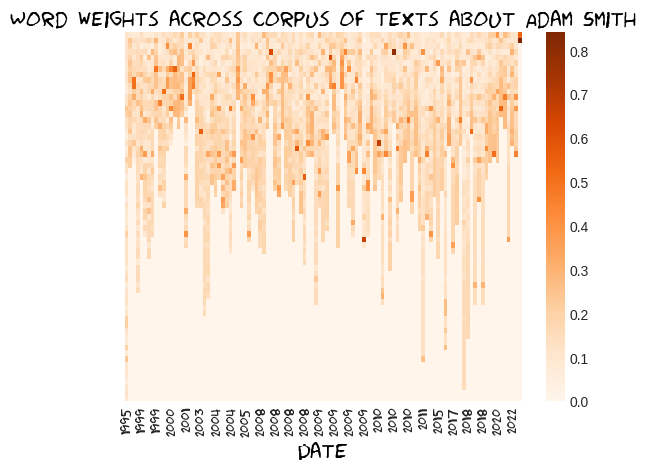

In [64]:
def build_heatmap_of_weights(all_tfidf_weights):
  weights_df = pd.DataFrame(all_tfidf_weights)
  for index, row in weights_df.iterrows():
    for i in range(len(row)):
      if row[i]:
        row[i] = row[i][1]
  weights_df = weights_df.fillna(0)
  weights_df.index = create_dates_list(df).year
  weights_df = weights_df.transpose()
  sns.heatmap(weights_df, cmap='Oranges')
  font = {'family':'fantasy','color':'black','size':15}
  plt.yticks([])
  plt.xticks(fontname="fantasy")
  plt.xlabel('Date', fontdict = font)
  plt.title('Word weights across corpus of texts about Adam Smith', fontdict = font)
  plt.show()
build_heatmap_of_weights(all_tfidf_weights)

In [79]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.tail())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length,Polarity,Subjectivity
Date,,,,,,,,
2021-10-06,We are a nation that exploded forth to be the ...,"People on both sides of the aisle, I have hear...",n/a,- capitalist system\n- essay on moral sentiments,Cory Anthony Booker \nDemocratic Party,273,-0.116667,0.466667
2021-10-07,That was 98 percent of the world. Fast-forward...,n/a,n/a,-Trade\n -division of labour \n- capitalism,Rand Paul\nRepublican Party,593,0.226667,0.413333
2022-07-19,"You go back, way back, to the godfather of cap...",n/a,n/a,- capitalism\n- to always watch out for the st...,Ms. KLOBUCHAR\nDemocratic Party,298,0.166667,0.296296
2022-07-26,"adam Smith—the godfather of capitalism, the gu...",n/a,n/a,- invisible hand\n- capitalism\n- Always watch...,Ms. KLOBUCHAR\nDemocratic Party,367,0.084091,0.288636
2023-03-09,Adam Smith’s Money World,"“honor one of my esteemed constituents, Alvin ...",! Adam Smith’s Money World was a long-running ...,n/a,Alvin H. Perlmutter is a prominent figure in t...,24,0.000000,0.000000


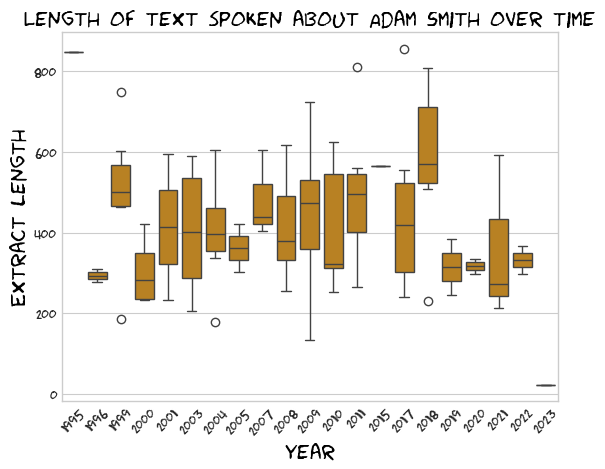

In [93]:
def create_boxplots_of_text_length(df):
  g = sns.boxplot(x=df.index.year, y=df['Extract length'], color='#D1870A')
  plt.style.use('seaborn-v0_8-whitegrid')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy", rotation=45)
  plt.yticks(fontname="fantasy")
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Extract length', fontdict = font)
  plt.title('Length of text spoken about Adam Smith over time', fontdict = font)
  plt.show()
create_boxplots_of_text_length(df)

In [66]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length,Polarity,Subjectivity
Date,,,,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",n/a,n/a,n/a,Peter Anthony DeFazio\nDemocratic Party,847,0.034375,0.404167
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",n/a,n/a,n/a,Raymond Eugene “Gene” Green\n Democratic Party,277,0.166667,0.400000
1996-05-23,"When wages fall, buying power drops, and all t...",n/a,n/a,n/a,Ronald Paul Klink\nDemocratic Party,310,0.383333,0.391667
1999-10-13,These arguments are no truer today than they w...,n/a,n/a,n/a,Paul David Wellstone\nDemocratic Party,748,0.055417,0.514167
1999-10-27,Go right back to Alexander Hamilton in the ear...,n/a,n/a,n/a,Ernest Frederick “Fritz” Hollings\nDemocratic ...,464,0.183036,0.222619


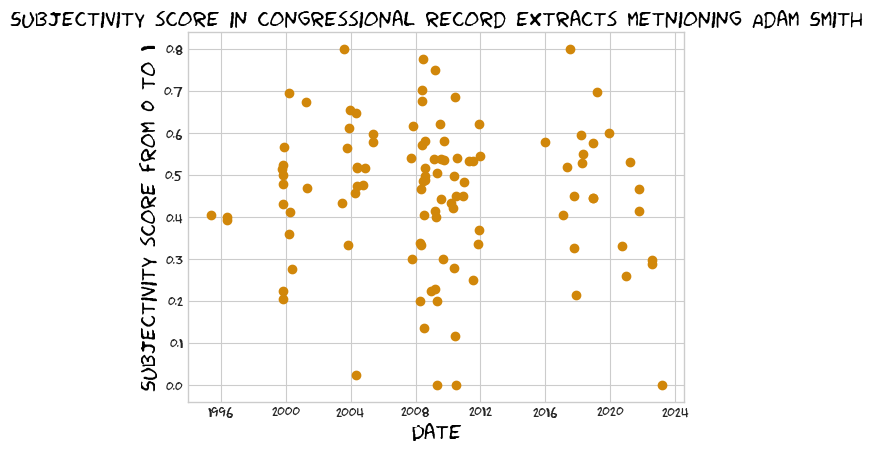

In [67]:
def plot_subjectivity_score(df):
  plt.scatter(df.index, df['Subjectivity'], color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.ylabel('Subjectivity score from 0 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Subjectivity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_subjectivity_score(df_sentiments)

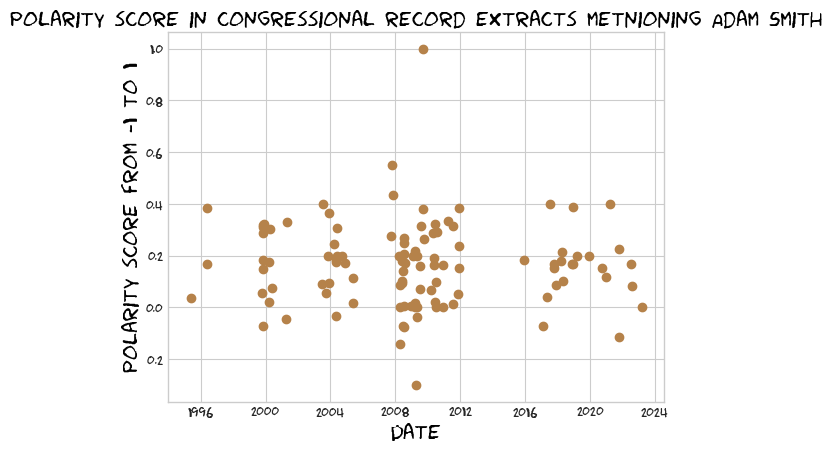

In [68]:
def plot_polarity_score(df):
  plt.scatter(df.index, df['Polarity'], color='#B5824A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.ylabel('Polarity score from -1 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Polarity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_polarity_score(df_sentiments)

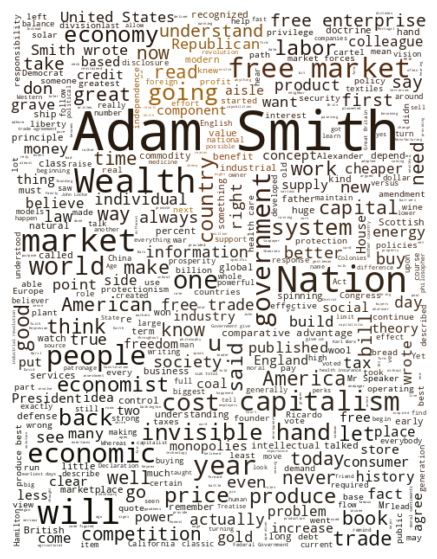

In [69]:
def word_cloud(df):
  stopwords = set(STOPWORDS)
  stopwords.update(['s', 't'])
  mask = np.array(Image.open("/content/adam-smith.jpg"))
  image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[7,7])
  text = ""
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=500, mask=mask).generate(text)
  plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [70]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)

Index(['1776', 'advantage', 'agree', 'aisle', 'amendment', 'america',
       'american', 'americans', 'base', 'based',
       ...
       'went', 'won', 'wool', 'work', 'works', 'world', 'wrote', 'year',
       'year 1776', 'years'],
      dtype='object', length=200)

   1776  advantage  agree  aisle  amendment  america  american  americans  \
0     0          0      0      0          0        2         0          0   
1     0          0      0      0          0        0         0          0   
2     0          0      0      0          0        0         0          0   
3     0          0      0      0          0        0         0          0   
4     0          2      0      0          0        0         0          0   

   base  based  ...  went  won  wool  work  works  world  wrote  year  \
0     0      0  ...     0    0     0     0      0      2      0     1   
1     0      0  ...     0    0     0     0      0      1      0     0   
2     0      0  ...     0    0     0     0      0      0      0     0   
3     0      0  ...     0    0     0     0      0      0      0     0   
4     0      0  ...     0    1     0     0      0      0      0     0   

   year 1776  years  
0          0      1  
1          0      0  
2          0      0  
3         